In [1]:
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
#

In [25]:
FWF_total_yearmin=3477 #averagae of 30 yr period: 1985-2014
year=2000 #1985-2014

In [26]:
path_input = f'/perm/nk0j/ecearth3-cmip6/runtime/classic/fwf/interactive/input/'

file_area = f'{path_input}/areacello_Ofx_EC-Earth3_historical_r1i1p1f1_gn.nc'
#file_baseline_fwf = f'{path_input}/TotalFW_Gt_1850_1930.txt' # !replace with piControl mean --> config?

file_basal_melt_mask = f'{path_input}/basal_melt_mask_ORCA1_ocean.nc'
file_calving_mask = f'{path_input}/calving_mask_ORCA1_ocean.nc'

file_forcing = f'{path_input}/FWF_LRF_y{year}.nc'

run_dir = '/scratch/nk0j/ecearth3-cmip6'
leg_number ='001'
exp_name = '5icu'
year = '1850'
file_thetao = f'{run_dir}/{exp_name}/output/nemo/{leg_number}/{exp_name}_1m_{year}0101_{year}1231_opa_grid_T_3D.nc' #other output format

In [27]:
# Constants
spy               = 3600*24*365   # [s yr^-1]
kg_per_Gt         = 1e12         # [kg] to [Gt]

In [5]:
# Baseline FWF freshwater forcing piControl mean
FWF_total_Gt = FWF_total_yearmin #Gt/yr
print('Total freshwater forcing: ', FWF_total_Gt, ' Gt per yr')

Total freshwater forcing:  3477  Gt per yr


In [6]:
basal_melt_mask = xr.open_dataset(file_basal_melt_mask)
calving_mask = xr.open_dataset(file_calving_mask)

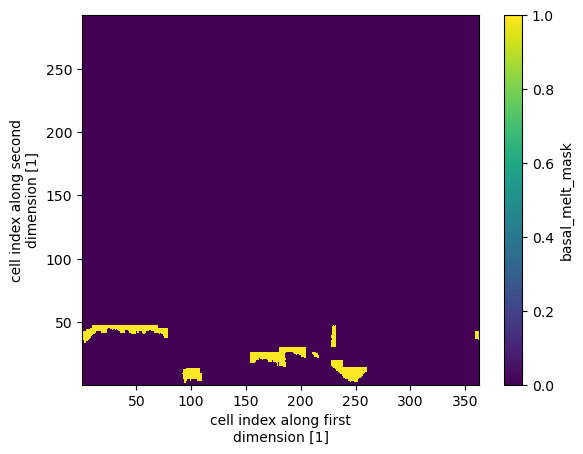

In [7]:
basal_melt_mask.basal_melt_mask.plot.pcolormesh()

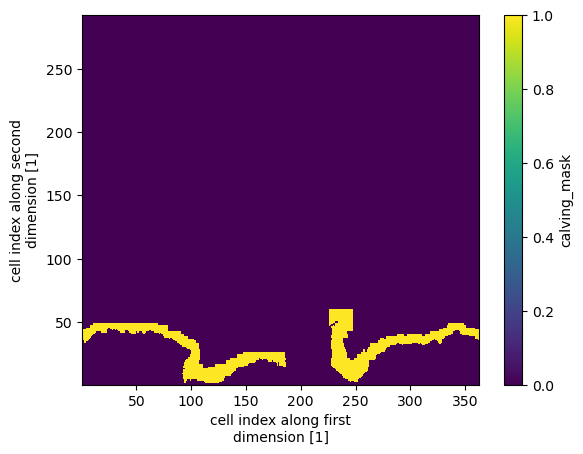

In [8]:
calving_mask.calving_mask.plot.pcolormesh()

In [9]:
## Open areacello dataarray and compute area corresponding with  distribution mask
ds_area = xr.open_dataset(file_area)

In [10]:
basal_melt_area = ds_area.areacello.where(basal_melt_mask.basal_melt_mask).sum('j').sum('i').values
calving_area = ds_area.areacello.where(calving_mask.calving_mask).sum('j').sum('i').values

print('Basal melt area: ', basal_melt_area*1.e-12, '10^6 km^2')
print('Calving area: ', calving_area*1.e-12, '10^6 km^2')


Basal melt area:  1.851847081984 10^6 km^2
Calving area:  5.84816001024 10^6 km^2


In [11]:
#The distribution of this total meltwater flux between basal melt and calving is fixed using the observed mass loss by Rignot et al. 2013 
FWF_calving_Gt = 0.45 * FWF_total_Gt
FWF_basal_melt_Gt = 0.55 * FWF_total_Gt

In [12]:

# Convert Gt yr-1 to kg m-2 s-1
#FWF_flux = df_total_FWF_Gt.values*kg_per_Gt/spy/float(distribution_area)
basal_melt_flux = FWF_basal_melt_Gt*kg_per_Gt/spy/float(basal_melt_area)
calving_flux = FWF_calving_Gt*kg_per_Gt/spy/float(calving_area)


In [13]:

# Apply flux to masked region
#FWF_distribution = FWF_flux*distribution_mask
#FWF_distribution = FWF_distribution.rename({'friver':'freshwater_flux'})
basal_melt_distribution = basal_melt_flux*basal_melt_mask
calving_distribution = calving_flux*calving_mask

In [14]:
# Rename variables for nemo
FWF_basal_melt = basal_melt_distribution.rename({'basal_melt_mask':'sorunoff_f'})
FWF_calving = calving_distribution.rename({'calving_mask':'socalving_f'})

FWF_calving


<xarray.Dataset>
Dimensions:      (j: 292, i: 362)
Coordinates:
    longitude    (j, i) float64 ...
    latitude     (j, i) float64 ...
  * i            (i) float64 1.0 2.0 3.0 4.0 5.0 ... 359.0 360.0 361.0 362.0
  * j            (j) float64 1.0 2.0 3.0 4.0 5.0 ... 289.0 290.0 291.0 292.0
Data variables:
    socalving_f  (j, i) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [16]:

## (Re)open thetao dataset to obtain time
ds = xr.open_dataset(file_thetao)
t = ds.time_counter
t


<xarray.DataArray 'time_counter' (time_counter: 12)>
array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', '1850-04-16T00:00:00.000000000',
       '1850-05-16T12:00:00.000000000', '1850-06-16T00:00:00.000000000',
       '1850-07-16T12:00:00.000000000', '1850-08-16T12:00:00.000000000',
       '1850-09-16T00:00:00.000000000', '1850-10-16T12:00:00.000000000',
       '1850-11-16T00:00:00.000000000', '1850-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 1850-01-16T12:00:00 ... 1850...
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1800-01-01 00:00:00
    bounds:         time_counter_bounds

In [35]:
#365*150+38 (number of days estimate between 2000 and 1850)

54788

In [40]:
# create new time coordinate for next simulation year (+ 1 yr)
t_new = t + np.timedelta64(54787,'D')
t_new

<xarray.DataArray 'time_counter' (time_counter: 12)>
array(['2000-01-17T12:00:00.000000000', '2000-02-16T00:00:00.000000000',
       '2000-03-16T12:00:00.000000000', '2000-04-16T00:00:00.000000000',
       '2000-05-16T12:00:00.000000000', '2000-06-16T00:00:00.000000000',
       '2000-07-16T12:00:00.000000000', '2000-08-16T12:00:00.000000000',
       '2000-09-16T00:00:00.000000000', '2000-10-16T12:00:00.000000000',
       '2000-11-16T00:00:00.000000000', '2000-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 1850-01-16T12:00:00 ... 1850...

In [41]:
# Add time dimension to dataarrays (12 months for the next year); flux is equal throughout the year
FWF_basal_melt = FWF_basal_melt.sorunoff_f.expand_dims({'time_counter': t.values})
FWF_basal_melt.attrs = {'long_name':'freshwater flux', 'units':'kg/m^2/s'}
FWF_basal_melt = FWF_basal_melt.fillna(0) #set nans to zeros


AttributeError: 'DataArray' object has no attribute 'sorunoff_f'

In [42]:

FWF_calving = FWF_calving.socalving_f.expand_dims({'time_counter': t.values})
FWF_calving.attrs = {'long_name':'freshwater flux', 'units':'kg/m^2/s'}
FWF_calving = FWF_calving.fillna(0) #set nans to zeros


AttributeError: 'DataArray' object has no attribute 'socalving_f'

In [43]:

# Merge dataarrays in one dataset
ds_FWF = xr.merge([FWF_basal_melt, FWF_calving])
ds_FWF = ds_FWF.assign_coords({'time_counter': t.values})
ds_FWF

<xarray.Dataset>
Dimensions:       (time_counter: 12, j: 292, i: 362)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1850-01-16T12:00:00 ... 1850-...
    longitude     (j, i) float64 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
    latitude      (j, i) float64 -78.39 -78.39 -78.39 ... 50.23 50.01 50.01
  * i             (i) float64 1.0 2.0 3.0 4.0 5.0 ... 359.0 360.0 361.0 362.0
  * j             (j) float64 1.0 2.0 3.0 4.0 5.0 ... 289.0 290.0 291.0 292.0
Data variables:
    sorunoff_f    (time_counter, j, i) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    socalving_f   (time_counter, j, i) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    long_name:  freshwater flux
    units:      kg/m^2/s

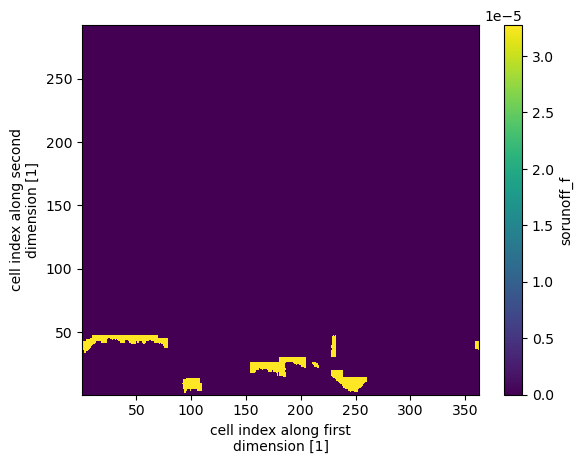

In [44]:
ds_FWF.sorunoff_f.mean('time_counter').plot.pcolormesh()

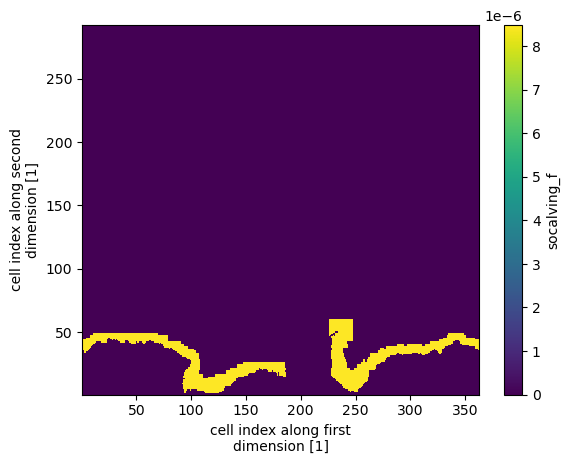

In [45]:
ds_FWF.socalving_f.mean('time_counter').plot.pcolormesh()

In [46]:
ds_FWF

<xarray.Dataset>
Dimensions:       (time_counter: 12, j: 292, i: 362)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1850-01-16T12:00:00 ... 1850-...
    longitude     (j, i) float64 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
    latitude      (j, i) float64 -78.39 -78.39 -78.39 ... 50.23 50.01 50.01
  * i             (i) float64 1.0 2.0 3.0 4.0 5.0 ... 359.0 360.0 361.0 362.0
  * j             (j) float64 1.0 2.0 3.0 4.0 5.0 ... 289.0 290.0 291.0 292.0
Data variables:
    sorunoff_f    (time_counter, j, i) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    socalving_f   (time_counter, j, i) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    long_name:  freshwater flux
    units:      kg/m^2/s

In [47]:

# Write to file  (to be read in by EC-Earth in the next year)
print(file_forcing)


/perm/nk0j/ecearth3-cmip6/runtime/classic/fwf/interactive/input//FWF_LRF_y2000.nc


In [48]:

if os.path.isfile(file_forcing):    
    os.remove(file_forcing)    

ds_FWF.to_netcdf(file_forcing, unlimited_dims=['time_counter'])